In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
from keras import backend as K
from experiment_mnist import *
from tfshow import *
import pickle

Using TensorFlow backend.


### Relu, 3 layers, 10x neurons, 0.5 dropout, K = 2

In [2]:
Layers = 3
KLips = 2
NNeurons = 10
activation = 'relu'
scaler = 1.0
epochs = 20
inputs = 20#00
acc_param = 50#00

In [6]:
def get_results(pfirst = 0.5, reg_type = 'delta', reg_coeff = 1e-4, repetition = 0):
    if reg_type == 0 and reg_coeff != 0:
        return {}
    print(pfirst, reg_type, reg_coeff, repetition)
    P = [pfirst] + [0] * (Layers - 1)
    N = [NNeurons] * Layers
    
    name = 'pfirst_%s_reg_type_%s_coeff_%s_repetition_%s' % (str(pfirst), str(reg_type), str(reg_coeff), str(repetition))
    
    model = MNISTExperiment(N, P, KLips, epochs = epochs, activation = activation, reg_type = reg_type,
                            reg_coeff = reg_coeff, do_print = True, scaler = scaler, name = name)
    
    model.update_C(model.get_inputs(10000))
    
    header = ['mean_exp', 'std_exp', 'mean_bound', 'std_bound', 'output_mean', 'output_variance']
    bound = model.run(inputs = inputs, repetitions = 1000)
    
    acc = model.get_accuracy(acc_param, acc_param, tqdm_ = tqdm)
    acc_orig = model.get_accuracy(acc_param, acc_param, tqdm_ = tqdm, no_dropout = True)
    
    results = {x: y for x, y in zip(header, bound)}
    results['acc_dropout'] = acc
    results['acc_orig'] = acc_orig
    results['W'] = model.W
    results['B'] = model.B
    K.clear_session()
    return results

In [4]:
pfirst_options = np.linspace(0, 1, 10)
reg_type_options = ['delta', 'l1', 'l2', 0]
reg_coeff_options = [0] + np.logspace(-10, 0, 30)
repetitions = range(10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
Total params: 8,180
Trainable params: 8,180
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 20/20 [00:06<00:00,  3.38it/s]


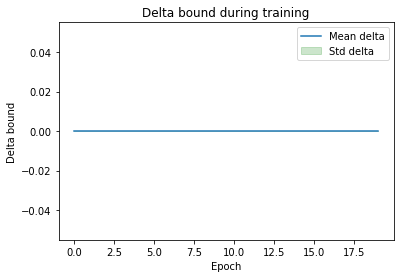

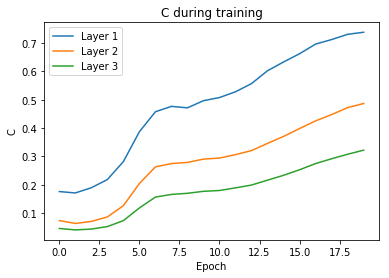

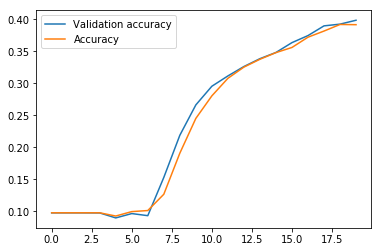

Creating network for 784-dimensional input and 10-dimensional output, with 3 hidden layers


100%|██████████| 20/20 [00:00<00:00, 83.00it/s]


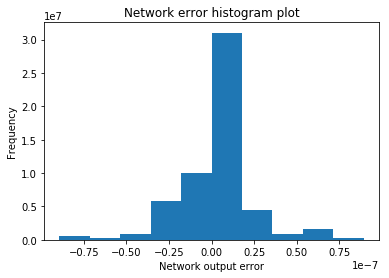

/localhome/volodin/probabilisticneuronfailurecode/experiment.py:191: RuntimeWarning: divide by zero encountered in double_scalars
  print('Tightness  %.1f%% Std %.1f%%' % (100 * mean_exp / mean_bound, 100 * std_exp / std_bound))
/localhome/volodin/probabilisticneuronfailurecode/experiment.py:191: RuntimeWarning: invalid value encountered in double_scalars
  print('Tightness  %.1f%% Std %.1f%%' % (100 * mean_exp / mean_bound, 100 * std_exp / std_bound))
100%|██████████| 50/50 [00:00<00:00, 3165.85it/s]

Error; maximal over inputs, average over dropout:
True values array mean: 0.093901 variance 0.091220
Experiment 0.000000 Std 0.000000
Equation   0.000000 Std 0.000000
Tightness  inf% Std nan%


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
Total params: 8,180
Trainable params: 8,180
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 20/20 [00:04<00:00,  4.99it/s]


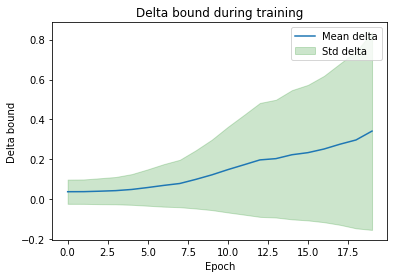

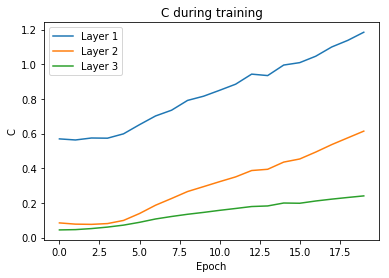

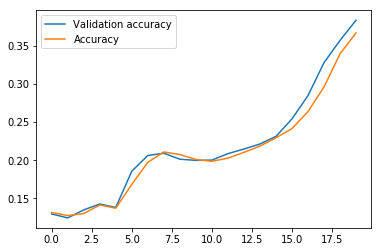

Creating network for 784-dimensional input and 10-dimensional output, with 3 hidden layers


100%|██████████| 20/20 [00:00<00:00, 77.32it/s]


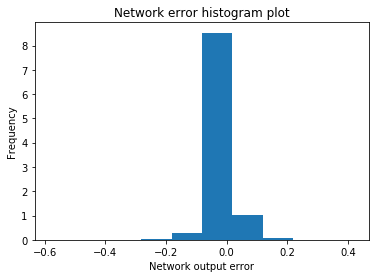

100%|██████████| 50/50 [00:00<00:00, 3464.53it/s]

Error; maximal over inputs, average over dropout:
True values array mean: 0.098037 variance 0.081754
Experiment 0.101325 Std 0.131688
Equation   0.363932 Std 0.523535
Tightness  27.8% Std 25.2%


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
Total params: 8,180
Trainable params: 8,180
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 20/20 [00:04<00:00,  5.02it/s]


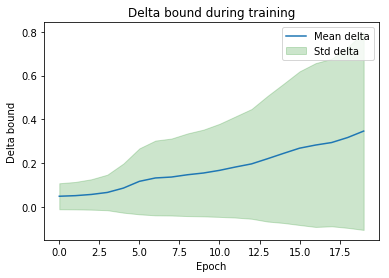

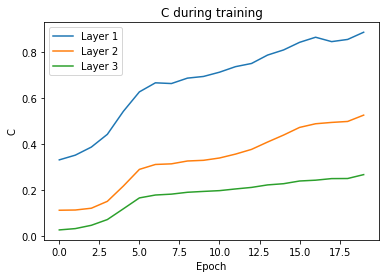

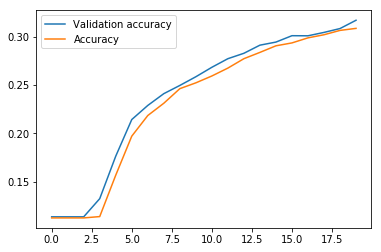

Creating network for 784-dimensional input and 10-dimensional output, with 3 hidden layers


100%|██████████| 20/20 [00:00<00:00, 79.71it/s]


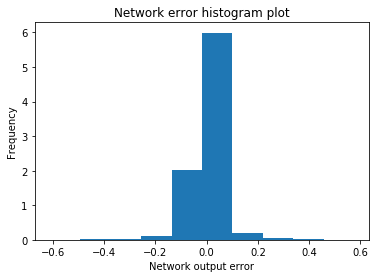

100%|██████████| 50/50 [00:00<00:00, 3425.71it/s]

Error; maximal over inputs, average over dropout:
True values array mean: 0.093832 variance 0.095746
Experiment 0.164085 Std 0.162424
Equation   0.370320 Std 0.484590
Tightness  44.3% Std 33.5%


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
Total params: 8,180
Trainable params: 8,180
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 20/20 [00:04<00:00,  5.08it/s]


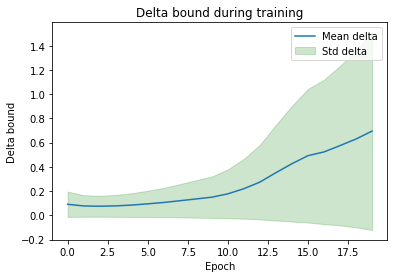

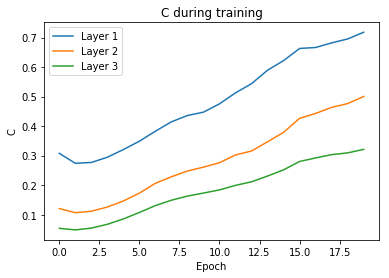

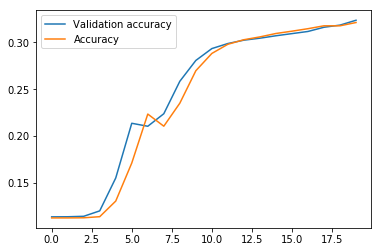

Creating network for 784-dimensional input and 10-dimensional output, with 3 hidden layers


100%|██████████| 20/20 [00:00<00:00, 75.27it/s]


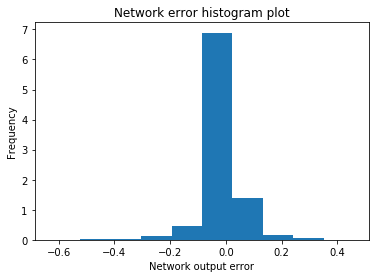

100%|██████████| 50/50 [00:00<00:00, 3492.40it/s]

Error; maximal over inputs, average over dropout:
True values array mean: 0.094732 variance 0.109220
Experiment 0.220839 Std 0.167524
Equation   0.680128 Std 0.799814
Tightness  32.5% Std 20.9%


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
Total params: 8,180
Trainable params: 8,180
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 20/20 [00:04<00:00,  5.15it/s]


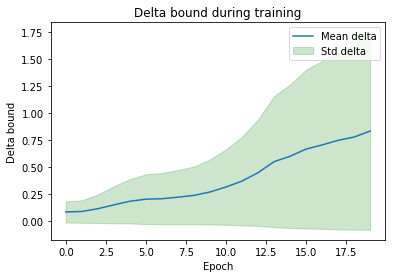

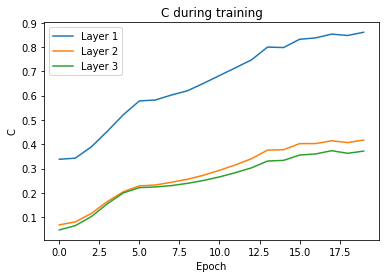

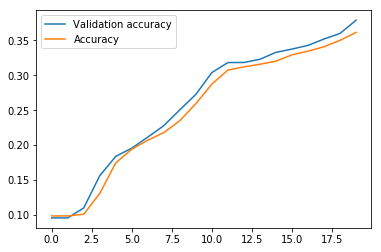

Creating network for 784-dimensional input and 10-dimensional output, with 3 hidden layers


100%|██████████| 20/20 [00:00<00:00, 72.14it/s]


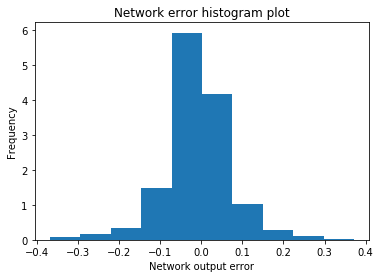

100%|██████████| 50/50 [00:00<00:00, 3287.38it/s]

Error; maximal over inputs, average over dropout:
True values array mean: 0.093897 variance 0.095602
Experiment 0.167436 Std 0.121868
Equation   0.883203 Std 0.961768
Tightness  19.0% Std 12.7%


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
Total params: 8,180
Trainable params: 8,180
Non-trainable params: 0
_________________________________________________________________


  0%|          | 0/20 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [5]:
results = {(pfirst, reg_type, reg_coeff, repetition): get_results(pfirst = pfirst, reg_type = reg_type, reg_coeff = reg_coeff, repetition = repetition)
 for repetition in repetitions
 for reg_coeff in reg_coeff_options
 for reg_type in reg_type_options
 for pfirst in pfirst_options
}

In [ ]:
pickle.dump(results, open('results_repeat.pkl', 'wb'))

### Comparing regularizers

In [ ]:
# method: l1/l2/delta
def plot_error(method = 'l1', coeffs = np.logspace(-10, 1, 30)):
    models = {}
    fail_accs = []
    orig_accs = []
    for coeff in coeffs:
        models[coeff] = MNISTExperiment(N, P, KLips, epochs = epochs, activation = activation, reg_type = method,
                                 reg_coeff = coeff, do_print = True)
        fail_accs += [models[coeff].get_accuracy(5000, 5000)]
        orig_accs += [models[coeff].get_accuracy(5000, no_dropout = True)]
        K.clear_session()
    plt.figure()
    plt.title(method + ' and resilience')
    plt.xlabel('Regularization coefficient')
    plt.ylabel('Accuracy')
    plt.plot(coeffs, fail_accs, label = 'Dropout')
    plt.plot(coeffs, orig_accs, label = 'No dropout')
    plt.plot(coeffs, [acc_no_reg] * len(coeffs), label = 'No reg, dropout')
    plt.plot(coeffs, [acc_no_reg_orig] * len(coeffs), label = 'No reg, no dropout')
    plt.xscale('log')
    plt.legend()
    plt.savefig(method + '.png')
    plt.show()